In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Data Helpers
def create_vocab(text):
    chars = sorted(set(text))
    char_to_ix = {ch: i for i, ch in enumerate(chars)}
    ix_to_char = {i: ch for i, ch in enumerate(chars)}
    return char_to_ix, ix_to_char

def one_hot_encode(index, vocab_size):
    vec = np.zeros((vocab_size, 1))
    vec[index] = 1
    return vec

In [3]:
# Activation
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / np.sum(e_x, axis=0)

def cross_entropy(y_pred, y_true_index):
    return -np.log(y_pred[y_true_index, 0] + 1e-9)

def d_cross_entropy(y_pred, y_true):
    grad = y_pred.copy()
    idx = np.argmax(y_true)
    grad[idx] -= 1
    return grad


In [4]:
# RNN Implementation
class CharRNN:
    def __init__(self, input_size, hidden_size, output_size):
        self.hidden_size = hidden_size
        self.Wxh = np.random.randn(hidden_size, input_size) * 0.01
        self.Whh = np.random.randn(hidden_size, hidden_size) * 0.01
        self.Why = np.random.randn(output_size, hidden_size) * 0.01
        self.bh = np.zeros((hidden_size, 1))
        self.by = np.zeros((output_size, 1))

    def forward(self, inputs):
        self.inputs = inputs
        self.hs = {}
        h = np.zeros((self.hidden_size, 1))
        self.hs[-1] = h
        outputs = []

        for t, x in enumerate(inputs):
            h = np.tanh(np.dot(self.Wxh, x) + np.dot(self.Whh, h) + self.bh)
            y = np.dot(self.Why, h) + self.by
            outputs.append(softmax(y))
            self.hs[t] = h
        return outputs

    def backward(self, targets, outputs, learning_rate=0.1):
        dWxh = np.zeros_like(self.Wxh)
        dWhh = np.zeros_like(self.Whh)
        dWhy = np.zeros_like(self.Why)
        dbh = np.zeros_like(self.bh)
        dby = np.zeros_like(self.by)
        dh_next = np.zeros((self.hidden_size, 1))

        for t in reversed(range(len(self.inputs))):
            dy = d_cross_entropy(outputs[t], targets[t])
            dWhy += np.dot(dy, self.hs[t].T)
            dby += dy

            dh = np.dot(self.Why.T, dy) + dh_next
            dh_raw = (1 - self.hs[t] ** 2) * dh
            dbh += dh_raw
            dWxh += np.dot(dh_raw, self.inputs[t].T)
            dWhh += np.dot(dh_raw, self.hs[t-1].T)
            dh_next = np.dot(self.Whh.T, dh_raw)

        for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
            np.clip(dparam, -1, 1, out=dparam)

        self.Wxh -= learning_rate * dWxh
        self.Whh -= learning_rate * dWhh
        self.Why -= learning_rate * dWhy
        self.bh  -= learning_rate * dbh
        self.by  -= learning_rate * dby

In [5]:
# Data Preparation 
text = "i will praper my paper"
char_to_ix, ix_to_char = create_vocab(text)
vocab_size = len(char_to_ix)

# Create training data
X_data = [one_hot_encode(char_to_ix[text[i]], vocab_size) 
          for i in range(len(text)-1)]
Y_data = [one_hot_encode(char_to_ix[text[i+1]], vocab_size) 
          for i in range(len(text)-1)]

In [6]:
# Training
rnn = CharRNN(input_size=vocab_size, hidden_size=16, output_size=vocab_size)
epochs = 2000
losses = []

for epoch in range(epochs):
    outputs = rnn.forward(X_data)
    # Adjust loss calculation to match cross_entropy's expected y_true_index
    loss = np.mean([cross_entropy(o, np.argmax(y)) for o, y in zip(outputs, Y_data)])
    losses.append(loss)
    
    rnn.backward(Y_data, outputs, learning_rate=0.1)
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")


Epoch 0, Loss: 2.3025
Epoch 100, Loss: 0.0121
Epoch 200, Loss: 0.0042
Epoch 300, Loss: 0.0025
Epoch 400, Loss: 0.0018
Epoch 500, Loss: 0.0014
Epoch 600, Loss: 0.0011
Epoch 700, Loss: 0.0009
Epoch 800, Loss: 0.0008
Epoch 900, Loss: 0.0007
Epoch 1000, Loss: 0.0006
Epoch 1100, Loss: 0.0006
Epoch 1200, Loss: 0.0005
Epoch 1300, Loss: 0.0005
Epoch 1400, Loss: 0.0004
Epoch 1500, Loss: 0.0004
Epoch 1600, Loss: 0.0004
Epoch 1700, Loss: 0.0004
Epoch 1800, Loss: 0.0003
Epoch 1900, Loss: 0.0003


In [7]:
# Text Generation
def generate_sequence(rnn, start_char, length, char_to_ix, ix_to_char):
    """Generate text sequence starting with given character."""
    idx = char_to_ix[start_char]
    x = one_hot_encode(idx, len(char_to_ix))
    h = np.zeros((rnn.hidden_size, 1))
    sequence = [start_char]

    for _ in range(length):
        h = np.tanh(np.dot(rnn.Wxh, x) + np.dot(rnn.Whh, h) + rnn.bh)
        y = np.dot(rnn.Why, h) + rnn.by
        probs = softmax(y)
        idx = np.random.choice(range(len(char_to_ix)), p=probs.ravel())
        x = one_hot_encode(idx, len(char_to_ix))
        sequence.append(ix_to_char[idx])

    return ''.join(sequence)


In [8]:
# Generate and print sample text
# Use 'i' as start character since 'd' is not in the text
generated_text = generate_sequence(rnn, 'i', 11, char_to_ix, ix_to_char)
print(f"Generated text: {generated_text}")

Generated text: i will prape


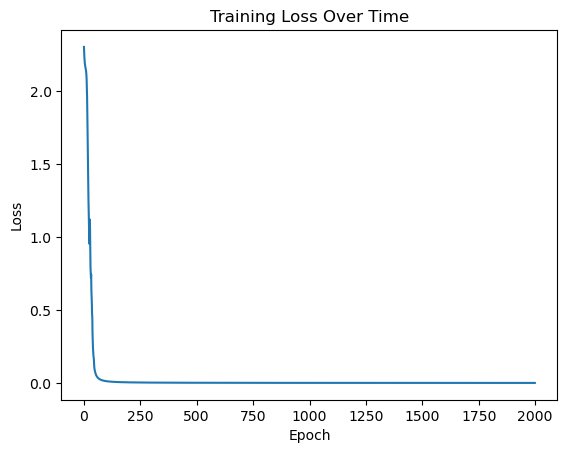

In [9]:
# Plot training loss
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.show()